# Анализ калибровки OOF и оценка модели

In [ ]:
# Стандартные импорты
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
                             brier_score_loss, confusion_matrix, precision_recall_curve, auc)
from sklearn.calibration import calibration_curve
import joblib

sns.set(style='whitegrid')

OOF_CSV = Path('../data/ru_toxic/combined_oof_full.csv')
MODEL_FILE = Path('../models/calibrated_model_full.joblib')

DATA_DIR = OOF_CSV.parent

Использую OOF CSV: ..\data\ru_toxic\combined_oof_full.csv
Ожидаемый путь модели: ..\models\calibrated_model_full.joblib


In [40]:
df = pd.read_csv(OOF_CSV)
print('Загружено', len(df), 'строк')
display(df.head())

Загружено 237873 строк


,text,label,soft_label
0,"видимо в разных регионах называют по разному ,...",0,0.036720
1,"понятно что это нарушение правил, писать капсл...",1,0.889414
2,"какие классные, жизненные стихи....",0,0.003488
3,а и правда-когда его запретили?...,0,0.076460
4,в соленой воде вирусы живут .ученые изучали со...,0,0.011058


In [ ]:
# Базовые метрики, вычисленные по OOF-предсказаниям
y = df['label'].astype(int).values
p = df['soft_label'].astype(float).values
th = 0.5
pred = (p >= th).astype(int)
metrics = {}
metrics['accuracy'] = accuracy_score(y, pred)
metrics['precision'] = precision_score(y, pred, zero_division=0)
metrics['recall'] = recall_score(y, pred, zero_division=0)
metrics['f1'] = f1_score(y, pred, zero_division=0)
metrics['roc_auc'] = roc_auc_score(y, p) if len(np.unique(y))>1 else np.nan
metrics['brier'] = brier_score_loss(y, p)
names_map = {
    'accuracy': 'Точность',
    'precision': 'Precision',
    'recall': 'Recall',
    'f1': 'F1',
    'roc_auc': 'ROC AUC',
    'brier': 'Brier score'
}
for k,v in metrics.items():
    print(f"{names_map.get(k,k)}: {v:.4f}")

Точность: 0.9409
Precision (точность позитивных): 0.9022
Recall (полнота): 0.7710
F1: 0.8315
ROC AUC: 0.9652
Brier score: 0.0455


## ROC-кривая и AUC

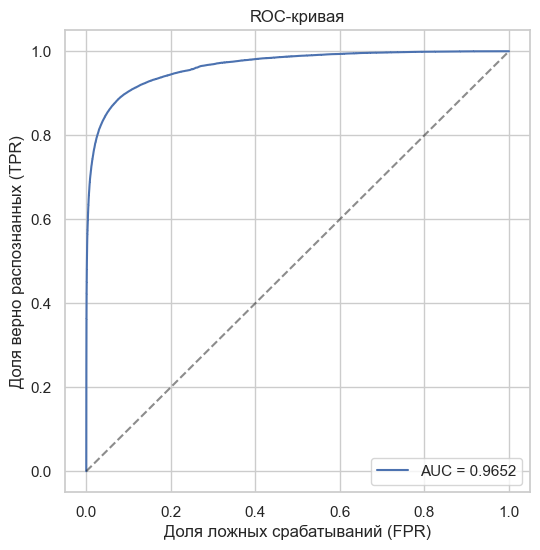

In [42]:
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(y, p)
plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f'AUC = {metrics["roc_auc"]:.4f}')
plt.plot([0,1],[0,1],'k--', alpha=0.5)
plt.xlabel('Доля ложных срабатываний (FPR)')
plt.ylabel('Доля верно распознанных (TPR)')
plt.title('ROC-кривая')
plt.legend()
plt.show()

## Кривая Precision–Recall

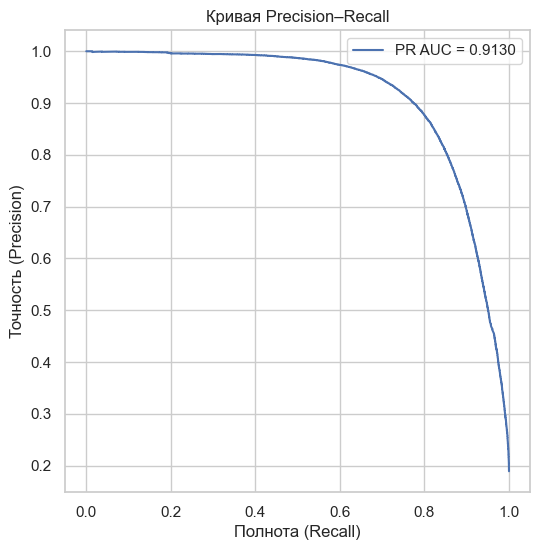

In [43]:
prec, rec, _ = precision_recall_curve(y, p)
pr_auc = auc(rec, prec)
plt.figure(figsize=(6,6))
plt.plot(rec, prec, label=f'PR AUC = {pr_auc:.4f}')
plt.xlabel('Полнота (Recall)')
plt.ylabel('Точность (Precision)')
plt.title('Кривая Precision–Recall')
plt.legend()
plt.show()

## Диаграмма надёжности (калибровочная кривая) и гистограмма предсказанных вероятностей

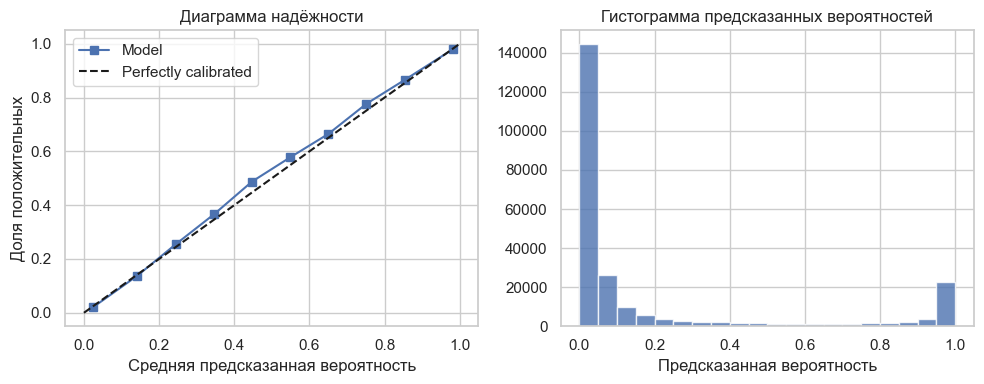

In [44]:
fraction_of_positives, mean_predicted_value = calibration_curve(y, p, n_bins=10)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(mean_predicted_value, fraction_of_positives, 's-', label='Model')
plt.plot([0,1],[0,1],'k--', label='Perfectly calibrated')
plt.xlabel('Средняя предсказанная вероятность')
plt.ylabel('Доля положительных')
plt.title('Диаграмма надёжности')
plt.legend()

plt.subplot(1,2,2)
plt.hist(p, bins=20, range=(0,1), color='C0', alpha=0.8)
plt.xlabel('Предсказанная вероятность')
plt.title('Гистограмма предсказанных вероятностей')
plt.tight_layout()
plt.show()

In [45]:
# Примерная оценка ожидаемой ошибки калибровки (ECE)
def expected_calibration_error(y_true, y_prob, n_bins=10):
    bins = np.linspace(0.0,1.0,n_bins+1)
    ece = 0.0
    for i in range(n_bins):
        bin_lower, bin_upper = bins[i], bins[i+1]
        mask = (y_prob >= bin_lower) & (y_prob < bin_upper)
        if mask.sum() == 0:
            continue
        prop = mask.mean()
        avg_confidence = y_prob[mask].mean()
        avg_accuracy = y_true[mask].mean()
        ece += (prop * abs(avg_confidence - avg_accuracy))
    return ece

ece = expected_calibration_error(y, p, n_bins=10)
print(f'ECE (10 бинов): {ece:.4f}')

ECE (10 бинов): 0.0053


## Матрица ошибок (порог = 0.5)

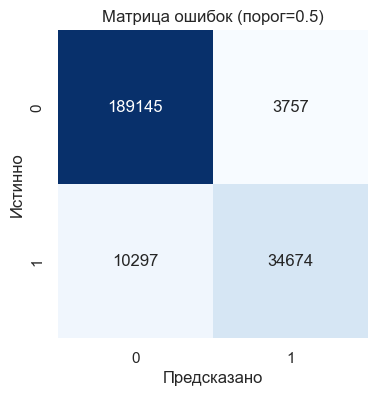

In [ ]:
cm = confusion_matrix(y, pred)
plt.figure(figsize=(4,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Предсказано')
plt.ylabel('Истинно')
plt.title('Матрица ошибок (порог=0.5)')
plt.show()